In [1]:
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import cmocean
from glob import glob
import pandas as pd
from copy import deepcopy
import gsw
import seaborn as sns
sns.set()

# Load data (and convert pressure to m)

In [2]:
data  = xr.open_dataset('ctd-data.nc')
data['p'] = -gsw.z_from_p(data['p'], lat=40.3)
data = data.rename({'p':'depth'})

# Plot

## Density

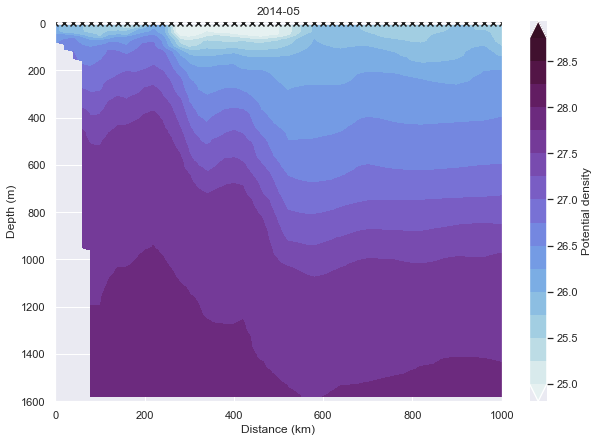

In [3]:
i = 0 # time index to plot
fig, ax = plt.subplots(figsize=(10,7)) # create canvas for plotting
p = ax.contourf(data.dist, data.depth, data.isel(time=i)['rho'].T, cmap='cmo.dense',
               levels=np.arange(25,29,.25), extend='both') # create contour plot
ax.scatter(data.dist, np.zeros(len(data.dist)),marker='x', color='k')
cb = fig.colorbar(p, orientation='vertical', label=r'Potential density') # create colorbar
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
ax.set_title(f'{y}-{m:02d}')
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.show()

## Temperature

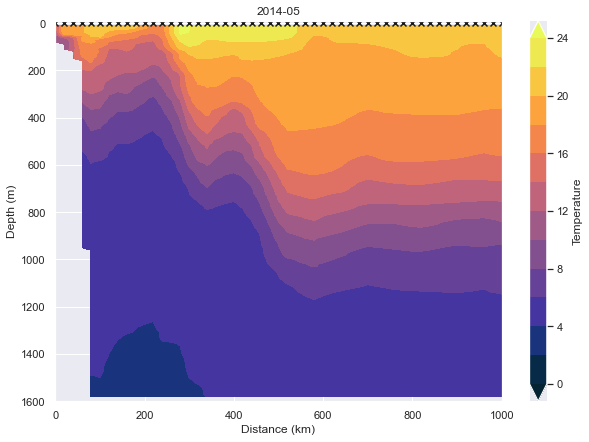

In [4]:
i = 0 # time index to plot
fig, ax = plt.subplots(figsize=(10,7)) # create canvas for plotting
p = ax.contourf(data.dist, data.depth, data.isel(time=i)['T'].T, cmap='cmo.thermal',
               levels=np.arange(0,25,2), extend='both') # create contour plot
ax.scatter(data.dist, np.zeros(len(data.dist)),marker='x', color='k')
cb = fig.colorbar(p, orientation='vertical', label=r'Temperature') # create colorbar
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
ax.set_title(f'{y}-{m:02d}')
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.show()

# Analysis

Compute geostrophic velocity based on "reduced gravity'' equations:  
$fv = g\nabla \eta_1$  
$\implies v = \frac{g}{f}\frac{\partial\eta_1}{\partial x}$

In [28]:
def get_iso(data, x):
    '''Given a dataset and the value of an isopycnal/therm, get coordinates of isopycnal/therm'''
    levels = np.array([x])
    idx = np.where(levels==x)[0].item()
    p = plt.contour(data['dist'], data['depth'], data['T'].T, levels=levels)
    plt.close()
    c = p.allsegs[idx][np.argmax([len(y) for y in p.allsegs[idx]])]
    return c

def get_iso_xr(data,x):
    '''Get isotherm, and horizontal gradient of the isotherm, from data'''
    iso = get_iso(data,x)
    iso = xr.DataArray(iso[:,1], coords={'dist':pd.Index(iso[:,0])}, dims=['dist'])
    iso = iso.interp(dist=data['dist'])
    grad  = iso.differentiate('dist') / 1000 # convert from km to m
    return iso, grad

def get_gprime(data, iso):
    '''Compute reduced gravity, based on isotherm/isopycnal'''
    # how to select pressure above and below based on isoline?
    rho     = data['rho']
    g       = 9.8 # full gravity
    gprimes = []
    for d in data.dist:
        boundary  = iso.sel(dist=d).values.item() 
        rho_lower = rho.sel(dist=d, depth=slice(boundary,None)).mean('depth')
        rho_upper = rho.sel(dist=d, depth=slice(None,boundary)).mean('depth')
        rho_prime = (rho_lower-rho_upper) / rho_upper
        gprimes.append(9.8 * rho_prime.values.item())
    gprime = deepcopy(iso)
    gprime.values = np.array(gprimes)
    return gprime

def est_velocity(data,x):
    '''Get estimated velocity from data, based on selected iso-line'''
    g     = 9.8 # acceleration due to gravity (NEED TO COMPUTE REDUCED GRAVITY!!!)
    omega = 2*np.pi/(3600*24) # rotation rate of earth (radians/sec)
    f     = 2*omega*np.sin(np.deg2rad(40.3)) # estimate of f0, based on latitude of ~40 degrees N
    iso, grad = get_iso_xr(data,x)    # Get isoline and compute horizontal gradient
    gprime    = get_gprime(data, iso) # Compute reduced gravity
    v         = gprime / f * grad    # velocity
    return iso, grad, v
    
iso, grad, v = est_velocity(data.isel(time=0), 15)

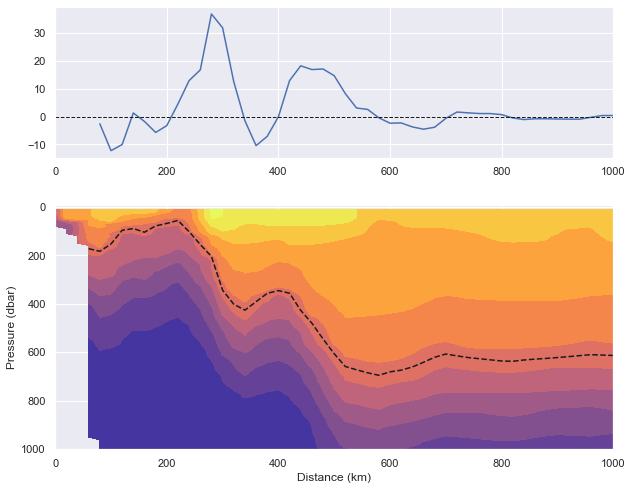

In [27]:
fig = plt.figure(figsize=(10,9))

ax0 = fig.add_subplot(2,1,1)
ax0.set_aspect(5)
ax0.plot(v.dist, v.values)
ax0.axhline(0,ls='--',lw=1,c='k')
ax0.set_xlim([0,1000])

ax = fig.add_subplot(2,1,2)
p = ax.contourf(data.dist, data.depth, data.isel(time=i)['T'].T, cmap='cmo.thermal',
               levels=np.arange(0,25,2), extend='both') # create contour plot
# cb = fig.colorbar(p, orientation='horizontal', label=r'Temperature') # create colorbar
ax.plot(iso.dist, iso.values, c='k', ls='--')
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1000])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.subplots_adjust(hspace=0)
plt.show()

# Old code

In [ ]:
def xgrad(arr):
    '''compute the x-derivative of data in array. First column is coordinate, second is data.'''
    x,y = arr[:,0], arr[:,1]
    y_diff = y[1:]-y[:-1]
    x_diff = x[1:]-x[:-1]
    return y_diff/x_diff 

def get_iso_grad(data,x):
    '''Compute the x-derivative of an isotherm/pycnal in the given data'''
    iso = get_iso(data, x)
    return xgrad(iso)